# Analyse des données liées au COVID-19 en France

## Importation des modules

In [100]:
import requests

In [101]:
from datetime import datetime

In [102]:
import pandas as pd 

In [103]:
import numpy as np 

In [104]:
import matplotlib.pyplot as plt 
%matplotlib inline

## Récupération du fichier .csv

In [105]:
# Récupération du fichier .csv à partir d'une URL stable
url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"

req = requests.get(url) # Envoi de la requête

if req.status_code == 200:
    print("LINK OK")
else:
    print(req.status_code)

url_content = req.content # Binary content
csv_file = open('cov.csv', 'wb')

csv_file.write(url_content)
csv_file.close()

cov = pd.read_csv('cov.csv', sep=";")

now = datetime.now()
when = now.strftime("%d/%m/%Y à %H:%M:%S")
print("Dernière mise à jour du CSV le", when)

LINK OK
Dernière mise à jour du CSV le 23/11/2020 à 20:42:25


## Exploration des données

In [106]:
# Dimensions du dataset (lignes, colonnes)
cov.shape

(76053, 7)

In [107]:
# Affichage des premières lignes
cov.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [108]:
# Affichage des dernières lignes
cov.tail()

,dep,sexe,jour,hosp,rea,rad,dc
76048,974,1,2020-11-23,47,8,295,20
76049,974,2,2020-11-23,40,7,298,24
76050,976,0,2020-11-23,11,4,505,35
76051,976,1,2020-11-23,7,2,242,21
76052,976,2,2020-11-23,4,2,257,14


In [109]:
# Description générale du dataset
cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76053 entries, 0 to 76052
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dep     76053 non-null  object
 1   sexe    76053 non-null  int64 
 2   jour    76053 non-null  object
 3   hosp    76053 non-null  int64 
 4   rea     76053 non-null  int64 
 5   rad     76053 non-null  int64 
 6   dc      76053 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 4.1+ MB


Informations sur les colonnes :

dep = département (type 'str' et non 'int' car dep. Corse = 2A et 2B)

sexe = 0 : h/f | 1 : h | 2 : f

jour = date enregistrement

hosp = nombre d'hospitalisations

rea = nombre de patients en réanimation

rad = Nombre de personnes retournées à domicile

dc = Nombre de décès en milieu hospitalier


## Visualisation

### Tout le territoire

#### Réanimations

In [110]:
cov_0 = cov.loc[cov['sexe'] == 0]
cov_rea = cov_0.groupby("jour").rea.sum()

Variation journalière = -53 [-1.18%] (Auj. : 4438, hier : 4491)


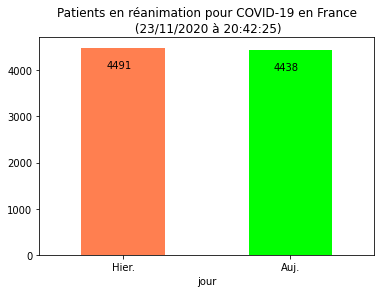

In [111]:
# Variations jour
last = cov_rea[len(cov_rea)-1]
b_last = cov_rea[len(cov_rea)-2]
diff = last - b_last
perc = round(((last/b_last)*100)-100, 2)

if last > b_last: # Variation +
    print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
    color = ["lime", "coral"]
elif last == b_last: # No variation
    print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
    color = ["b", "b"]
else : # Variation -
    print(f"Variation journalière = {diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
    color = ["coral", "lime"]

df = pd.DataFrame({'jour':['Hier.', 'Auj.'], 'réa':[b_last, last]})

ax = df.plot.bar(x='jour', y='réa', rot=0, color=color, legend=False, title = f"Patients en réanimation pour COVID-19 en France\n ({when})")

x_offset = -0.1

for p in ax.patches:
    b = p.get_bbox()
    #print(b)
    val = "{:.0f}".format(b.y1)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 - (b.y1/10)))

In [112]:
# Variation semaine
last_week = []
b_last_week = []
i = len(cov_rea)-1

while i > (len(cov_rea)-1) - 7:
    last_week.append(cov_rea[i])
    i-=1

while i > (len(cov_rea)-1) - 14:
    b_last_week.append(cov_rea[i])
    i-=1

lw_sum = sum(last_week)
blw_sum = sum(b_last_week)
diff = lw_sum - blw_sum
perc = round(((lw_sum/blw_sum)*100)-100, 2)

if lw_sum > blw_sum:
    print(f"Variation hébomadaire = +{diff} [{perc}%] (Cette sem. : {lw_sum}, Sem. der. : {blw_sum})")
else:
    print(f"Variation hébomadaire = {diff} [{perc}%] (Sem. : {lw_sum}, Sem. der. : {blw_sum})")

Variation hébomadaire = -1712 [-5.05%] (Sem. : 32222, Sem. der. : 33934)


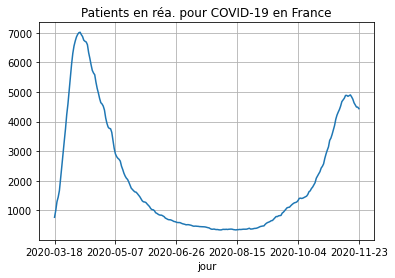

In [113]:
# Réanimations
rea_graph = cov_rea.plot(grid=True, title="Patients en réa. pour COVID-19 en France")

<AxesSubplot:title={'center':'Variation rea.'}>

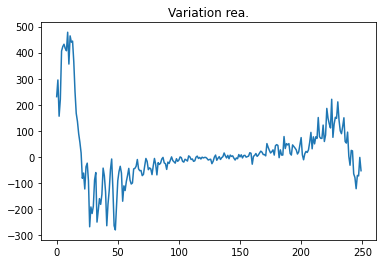

In [114]:
hosp_cov = cov_0.groupby("jour").hosp.sum()
def ratio(x): # <list>

    i = 1
    loop = 0
    L = []

    while loop < len(x) - 1 :
        res = x[i] - x[i - 1]
        #res = abs(res)
        L.append(res)
        i += 1
        loop += 1

    L = pd.Series(L)

    return L #<list>

#cov_rea_list = list(cov_rea)
out = ratio(cov_rea)
#out_2 = ratio(hosp_cov)

out.plot(title = "Variation rea.")
#out_2.plot()

#### Hospitalisations

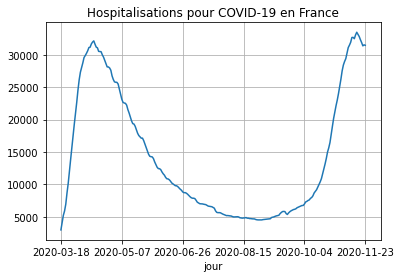

In [115]:
# Hospitalisations
hosp_graph = hosp_cov.plot(grid=True, title="Hospitalisations pour COVID-19 en France")

#### Décès

<AxesSubplot:title={'center':'Variation du nombre de décès par jour\n en milieu hospitalier suite à la COVID-19 en France'}, xlabel='jour'>

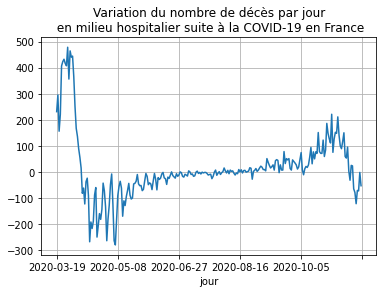

In [116]:
cov_dc = cov_0.groupby("jour").dc.sum()

def ratio(x): # <list>

    i = 1
    loop = 0
    L = []

    while loop < len(x) - 1 :
        res = x[i] - x[i - 1]
        #res = abs(res)
        L.append(res)
        i += 1
        loop += 1

    L = pd.Series(L)

    return L #<list>

cov_rea_var = ratio(cov_rea)
date_idx = cov_rea.index # Extract index
date_idx = date_idx.delete(0) # Delete 1st index value
cov_rea_var.index = date_idx # Replace the index

cov_rea_var.plot(grid = True, title="Variation du nombre de décès par jour\n en milieu hospitalier suite à la COVID-19 en France")

<AxesSubplot:title={'center':'Nombre de décès cumulé en milieu hospitalier\n suite à la COVID-19 en France'}, xlabel='jour'>

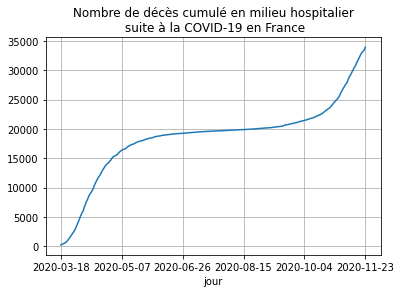

In [117]:
cov_dc.plot(grid=True, title="Nombre de décès cumulé en milieu hospitalier\n suite à la COVID-19 en France")

#### Réanimations / Hospitalisations

<class 'matplotlib.axes._subplots.AxesSubplot'>


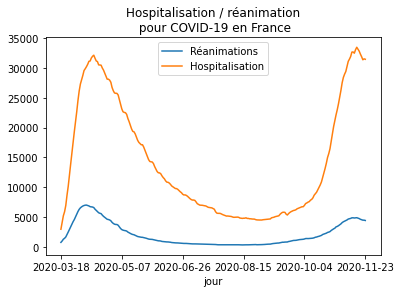

In [118]:
cov_rea.to_frame()
hosp_cov.to_frame()
rea_graph = cov_rea.plot(x="jour", y="rea")
hosp_graph = hosp_cov.plot(x="jour", y="hosp", title="Hospitalisation / réanimation\n pour COVID-19 en France")
hosp_graph.legend(["Réanimations", "Hospitalisation"])
print(type(hosp_graph))

### Par département

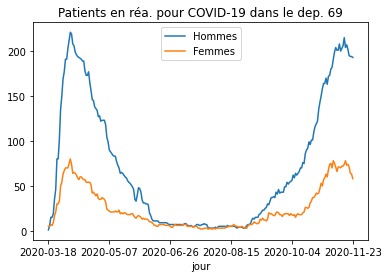

In [119]:
dep = "69" # Changer le département
cov_dep = cov.loc[cov['dep'] == dep]

cov_dep_0 = cov_dep.loc[cov_dep['sexe'] == 0] # Just H/F
cov_dep_1 = cov_dep.loc[cov_dep['sexe'] == 1] # Just H
cov_dep_2 = cov_dep.loc[cov_dep['sexe'] == 2] # Just F

title = f"Patients en réa. pour COVID-19 dans le dep. {dep}"

rea_1 = cov_dep_1.plot(x="jour", y="rea")
rea_2 = cov_dep_2.plot(x="jour", y="rea", ax=rea_1, grid=False, title = title)
rea_2.legend(["Hommes", "Femmes"])

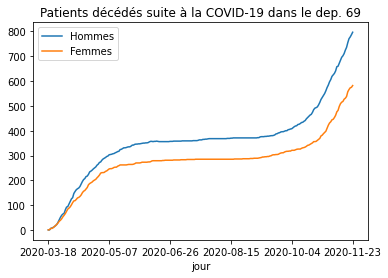

In [120]:
dep = "69"

cov_dep = cov.loc[cov['dep'] == dep]

cov_dep_0 = cov_dep.loc[cov_dep['sexe'] == 0] # Just H/F
cov_dep_1 = cov_dep.loc[cov_dep['sexe'] == 1] # Just H
cov_dep_2 = cov_dep.loc[cov_dep['sexe'] == 2] # Just F

title = f"Patients décédés suite à la COVID-19 dans le dep. {dep}"

dc_1 = cov_dep_1.plot(x="jour", y="dc")
dc_2 = cov_dep_2.plot(x="jour", y="dc", ax=dc_1, grid=False, title = title)
dc_2.legend(["Hommes", "Femmes"])